In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from tqdm import tqdm
import re

from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import time
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import _tree
from sklearn import tree

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### Functions

In [2]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return(vif)

In [3]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [4]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [5]:
#########################
### Feature selection ###
#########################

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [128]:
############################################
### Data sub populations from tree model ###
############################################

def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]            
        
    return rules, proba

In [ ]:
def diag_vals(model):

  y_pred = model.predict(X_test)

  mae = mean_absolute_error(y_test, y_pred)
  print("MAE: ", mae)

  rmse = mean_squared_error(y_test, y_pred, squared=False)
  print("RMSE: ", rmse)

  r2 = r2_score(y_test, y_pred)
  print("R2 score: ", r2)

  return mae, rmse, r2

### Read in data

In [6]:
data = pd.read_csv('Insurance_Company_Complaints__Resolutions__Status__and_Recoveries.csv')
print(data.shape)
data.Opened = pd.to_datetime(data.Opened)
data.Closed = pd.to_datetime(data.Closed)
data.Conclusion = data.Conclusion.fillna('Missing')
data = data.drop_duplicates()
print(data.shape)
data.head()

(38267, 12)
(37484, 12)


,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
0,"Anthem Health Plans, Inc",7045593,2022-05-31,2022-06-02,Group,Health Only,Claim Handling,Medically Necessary,Company Position Substantiated,Company Position Upheld,0.00,Closed
1,"Anthem Health Plans, Inc",7043381,2022-02-28,2022-06-02,Group,Health Only,Claim Handling,Provider Contract Issue,Claim Settled,Satisfied,6467.30,Closed
2,"Anthem Health Plans, Inc",7044860,2022-05-03,2022-06-02,A & H,Health Only,Claim Handling,Denial,Claim Settled,Claim Paid,147.58,Closed
3,"Anthem Health Plans, Inc",7043381,2022-02-28,2022-06-02,Group,A & H,Claim Handling,Provider Contract Issue,Claim Settled,Satisfied,6467.30,Closed
4,"Anthem Health Plans, Inc",7052007,2023-02-23,2023-03-17,A & H,A & H,Marketing & Sales,Duplicate Coverage,Compromised Settlement/Resolution,Premium Refund,2179.32,Closed


In [7]:
nonvar_lst = []

for i in range(data.shape[1]):
    print('Column: ', data.columns[i], ', number of unique classes: ', data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print('Values: ', list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])
        


Column:  Company , number of unique classes:  765
Column:  File No. , number of unique classes:  20537
Column:  Opened , number of unique classes:  1603
Column:  Closed , number of unique classes:  1377
Column:  Coverage , number of unique classes:  53
Column:  SubCoverage , number of unique classes:  102
Column:  Reason , number of unique classes:  4
Values:  ['Claim Handling', 'Marketing & Sales', 'PolicyHolder Service', 'Underwriting', nan]
Column:  SubReason , number of unique classes:  179
Column:  Disposition , number of unique classes:  13
Values:  ['Insufficient Information', 'Claim Reopened', 'Complaint Withdrawn', 'Compromised Settlement/Resolution', 'Company Position Overturned', 'Claim Settled', 'No Jurisdiction', 'Referred to Another State’s Dept of Insurance', 'Company Position Substantiated', 'Question of Fact/Contract/Provision/Legal Issue', 'No Action Requested/Required', 'Referred to Outside Agency/Dept', 'Referred to Other Division for Possible Disciplinary Action', 

In [8]:
print(nonvar_lst)

[]


### Target variable

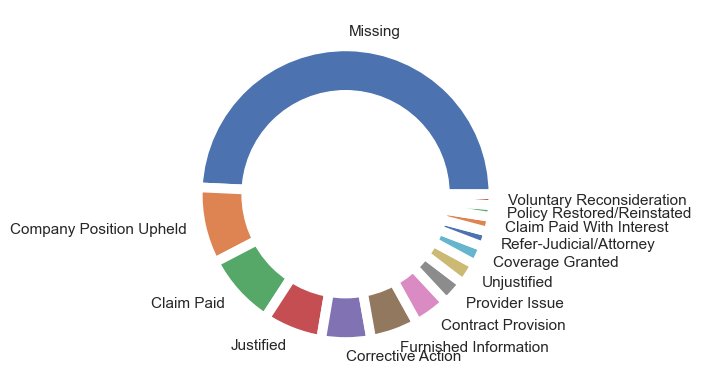

In [9]:
name = 'Conclusion'
c_loc = data.sort_values(by = name)
c_loc = c_loc.groupby([name]).size().to_frame('Count').reset_index()
c_loc['perc'] = c_loc['Count']/data.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)
c_loca = c_loc[c_loc.cum_perc < 90]

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(c_loca.perc, labels=c_loca[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [10]:
c_loc.tail(10)

,Conclusion,Count,perc,cum_perc
43,Deductible Recovered,5,0.013339,99.935973
44,Underwriting Discretion,4,0.010671,99.946644
45,Accident in Another State,4,0.010671,99.957315
46,Rate Problem Solved,4,0.010671,99.967986
47,Policy Offered,4,0.010671,99.978658
48,Fees Returned,4,0.010671,99.989329
49,Filed Errors&Omission Clm,1,0.002668,99.991997
50,Extl Rev Info Sent/SF,1,0.002668,99.994664
51,Cross Reference Only,1,0.002668,99.997332
52,Med Jurisdiction Explained,1,0.002668,100.000000


### Missing data

In [11]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/data.shape[0]*100
check

,Count,perc
Company,0,0.000000
File No.,0,0.000000
Opened,0,0.000000
Closed,963,2.569096
Coverage,2439,6.506776
SubCoverage,8872,23.668765
Reason,2574,6.866930
SubReason,2574,6.866930
Disposition,15095,40.270515
Conclusion,0,0.000000


### Closed complaints

In [12]:
pd.crosstab(data.Closed.isna(), data.Conclusion.isna())

Conclusion,False
Closed,
False,36521
True,963


/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_2786/3197213151.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_closed.Opened = pd.to_datetime(not_closed.Opened)
/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_2786/3197213151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_closed.Closed = pd.to_datetime(not_closed.Closed)


(963, 12)


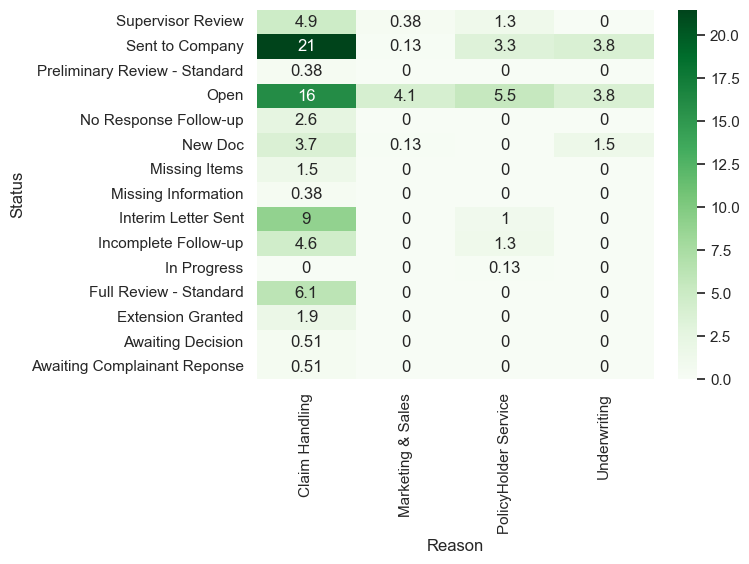

In [13]:
not_closed = data[data.Closed.isna()]

not_closed.Opened = pd.to_datetime(not_closed.Opened)
not_closed.Closed = pd.to_datetime(not_closed.Closed)

print(not_closed.shape)

cross_tab = pd.DataFrame(pd.crosstab(not_closed.Status, not_closed.Reason, normalize='all'))
cross_tab = cross_tab * 100

ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
ax.invert_yaxis()
plt.show();

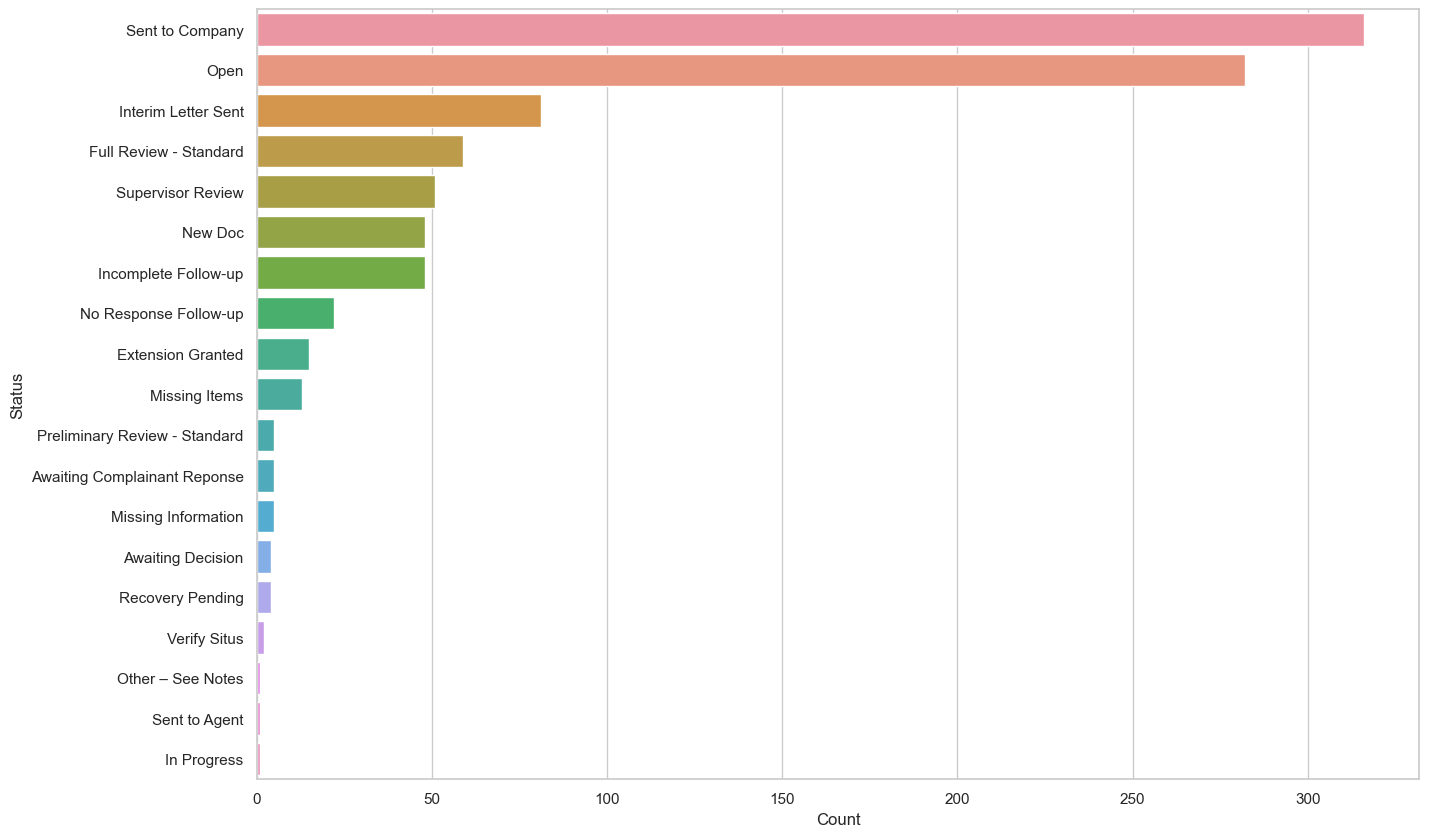

In [14]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10))

not_closed_c = not_closed.groupby(['Status']).size().to_frame('Count').reset_index()
not_closed_c = not_closed_c.sort_values("Count", ascending=False).reset_index(drop=True)
#not_closed_c = not_closed_c.iloc[:20,:]

sns.set_color_codes("muted")
sns.barplot(y="Status", x="Count", 
            data=not_closed_c,
            label="Company", 
            orient = "h")
plt.show();

In [15]:
print(min(not_closed.Opened), max(not_closed.Opened))




2016-12-05 00:00:00 2023-07-29 00:00:00


### Closed data

In [16]:
closed = data[~data.Closed.isna()]

print(min(closed.Opened), max(closed.Opened))
print(min(closed.Closed), max(closed.Closed))

2015-09-28 00:00:00 2023-07-26 00:00:00
2018-01-02 00:00:00 2023-07-31 00:00:00


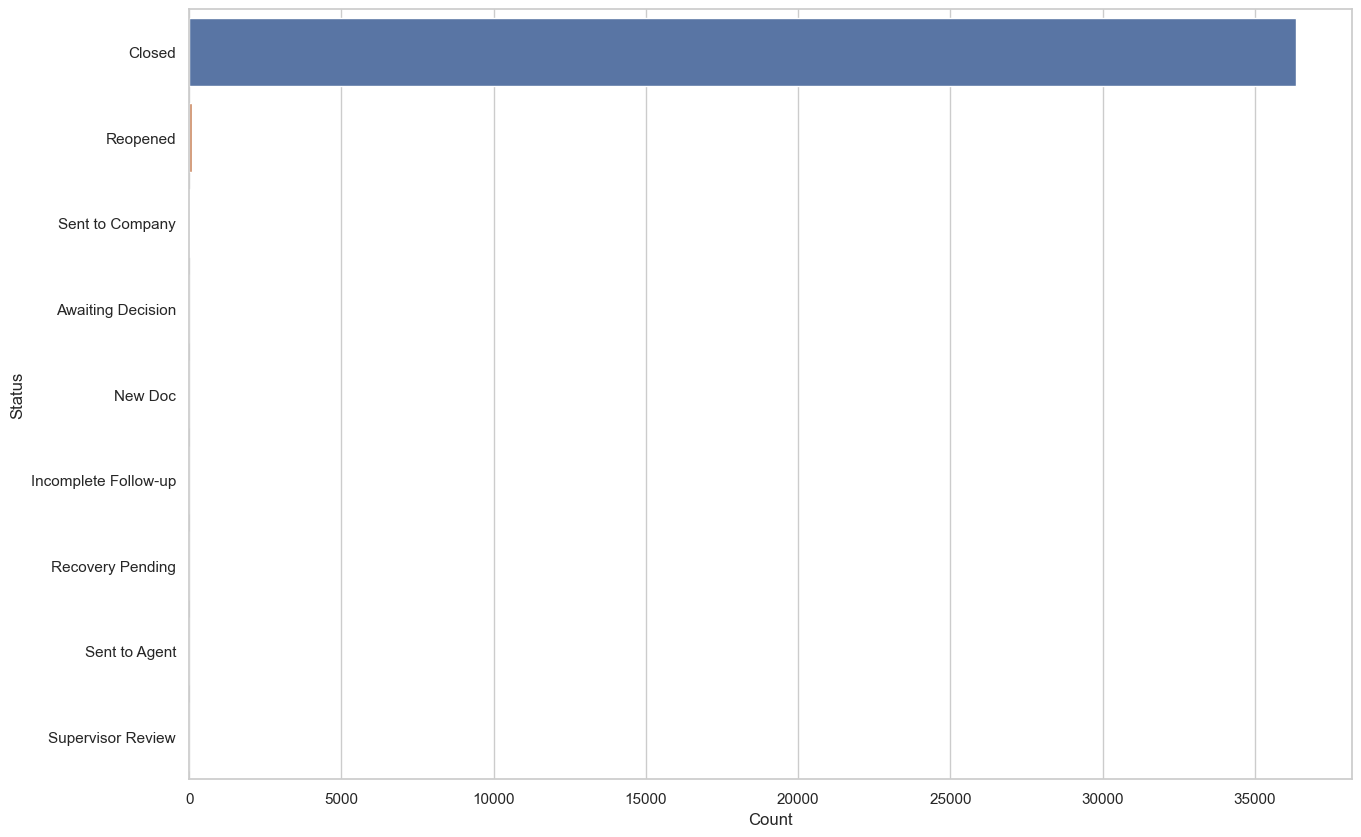

In [17]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10))

closed_status = closed.groupby(['Status']).size().to_frame('Count').reset_index()
closed_status = closed_status.sort_values("Count", ascending=False).reset_index(drop=True)

sns.set_color_codes("muted")
sns.barplot(y = "Status", x = "Count", 
            data = closed_status,
            label = "Status", 
            orient = "h")
plt.show();

In [63]:
closed['duration'] = closed.Closed - closed.Opened
closed['duration'] = closed['duration'].dt.days
#closed['duration'].describe()

c_loc = closed.sort_values(by = 'Conclusion')
c_loc = c_loc.groupby(['Conclusion']).size().to_frame('Count').reset_index()
c_loc = c_loc.sort_values(['Count'], ascending = False).reset_index()
c_loc = c_loc.iloc[:15,:]

closed.loc[~closed.Conclusion.isin(list(c_loc.Conclusion)), 'Conclusion'] = 'Other'

for name in ['Company', 'Coverage', 'SubCoverage', 'Reason', 'SubReason', 'Disposition', 'Status']:

    closed[name] = closed[name].str.replace(r'-', r'_')
    closed[name] = closed[name].str.replace(r' ', r'_')
    closed[name] = closed[name].str.replace(r'&', r'_')
    closed[name] = closed[name].str.replace(r'.', r'_')
    closed[name] = closed[name].str.replace(r'(', r'_')
    closed[name] = closed[name].str.replace(r')', r'_')
    closed[name] = closed[name].str.replace(r'/', r'')
    closed[name] = closed[name].str.replace(r',', r'')
    closed[name] = closed[name].str.replace(r'__', r'_')
    closed[name] = closed[name].str.replace(r"[\"\',]", '')
    closed[name] = closed[name].str.lstrip()
    closed[name] = closed[name].str.rstrip()

/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_2786/3516805916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed['duration'] = closed.Closed - closed.Opened
/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_2786/3516805916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed['duration'] = closed['duration'].dt.days
/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_2786/3516805916.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_2786/4263272169.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


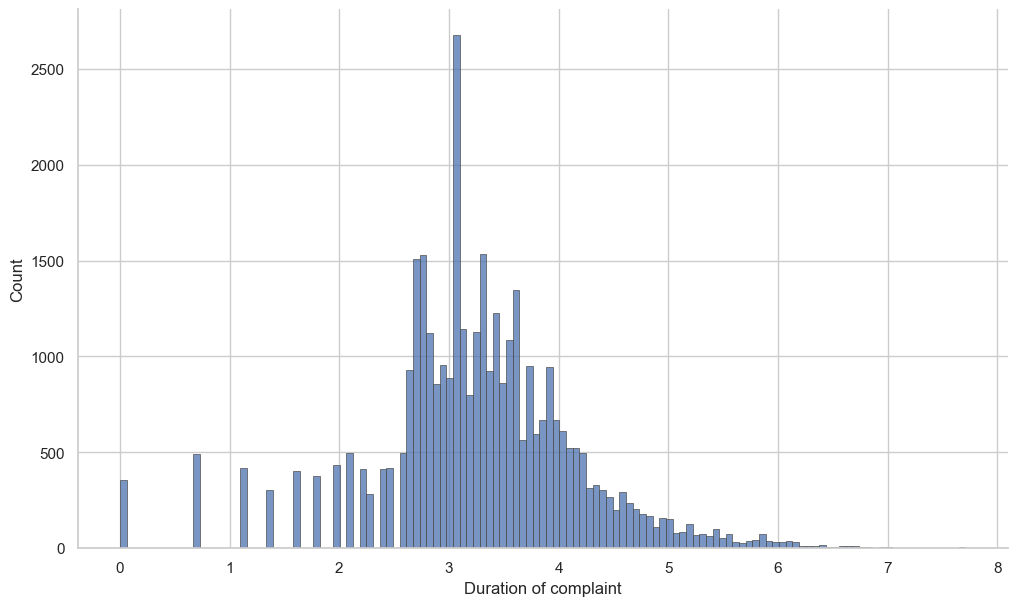

In [19]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

closeda = closed[~closed.duration.isna()].copy()
closeda['log_duration'] = np.log(closeda.duration + 1) 

sns.histplot(
    closeda,
    x="log_duration", 
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Duration of complaint")
plt.show();

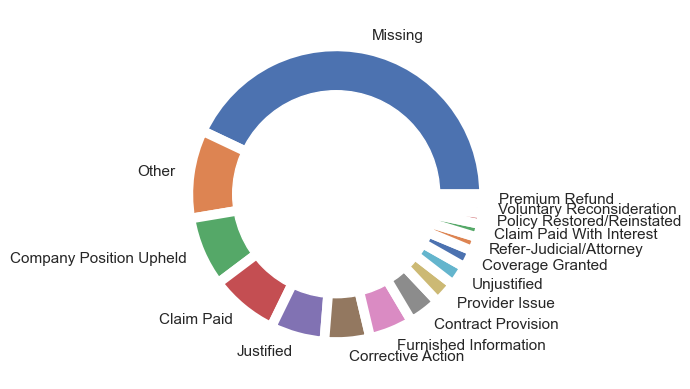

In [20]:
name = 'Conclusion'
c_loc = closed.sort_values(by = name)
c_loc = c_loc.groupby([name]).size().to_frame('Count').reset_index()
c_loc['perc'] = c_loc['Count']/closed.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [21]:
c_loc.tail(10)

,Conclusion,Count,perc,cum_perc
6,Furnished Information,1763,4.827360,83.540976
7,Contract Provision,1278,3.499357,87.040333
8,Provider Issue,909,2.488979,89.529312
9,Unjustified,823,2.253498,91.782810
10,Coverage Granted,709,1.941349,93.724159
11,Refer-Judicial/Attorney,567,1.552531,95.276690
12,Claim Paid With Interest,534,1.462172,96.738863
13,Policy Restored/Reinstated,429,1.174667,97.913529
14,Voluntary Reconsideration,401,1.097998,99.011528
15,Premium Refund,361,0.988472,100.000000


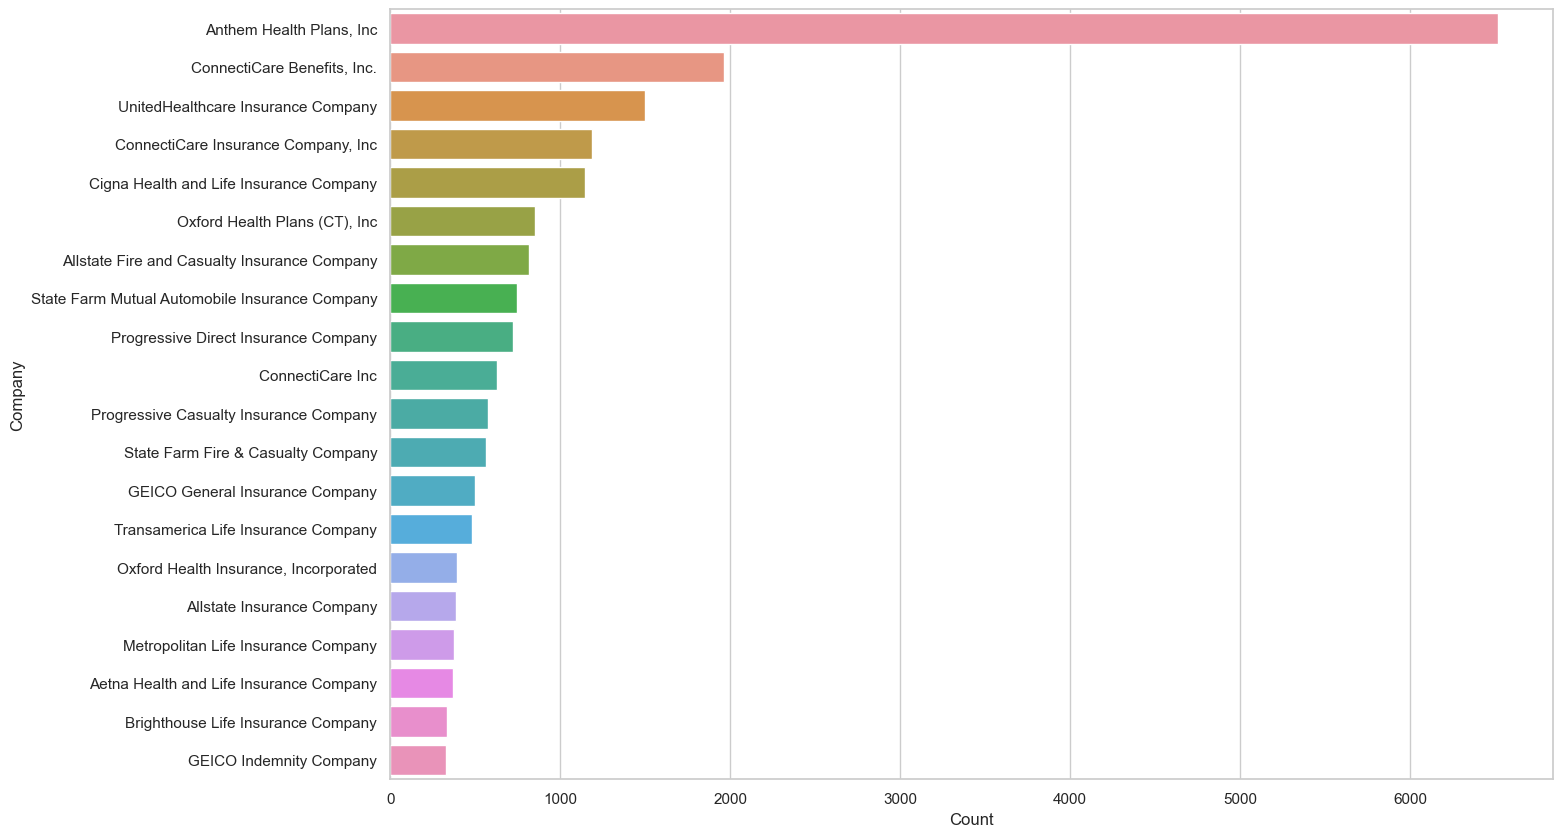

In [22]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10))

closed_c = closed.groupby(['Company']).size().to_frame('Count').reset_index()
closed_c = closed_c.sort_values("Count", ascending=False).reset_index()
closed_c = closed_c.iloc[:20,:]

sns.set_color_codes("muted")
sns.barplot(y="Company", x="Count", 
            data=closed_c,
            label="Company", 
            orient = "h")
plt.show();

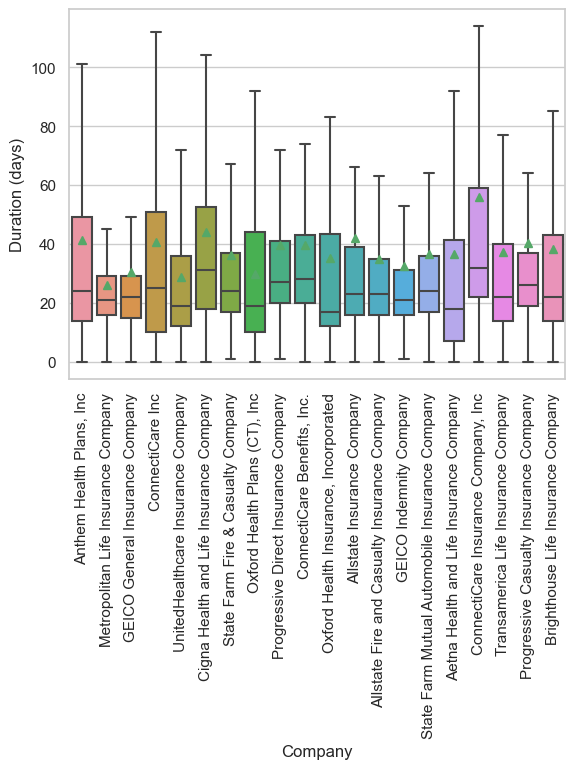

In [23]:
closed_cop = closed[closed.Company.isin(list(closed_c.Company))]

sns.boxplot(data=closed_cop, x="Company", y="duration", showfliers = False, showmeans = True)
plt.xlabel("Company")
plt.xticks(rotation=90)
plt.ylabel("Duration (days)")
plt.show()

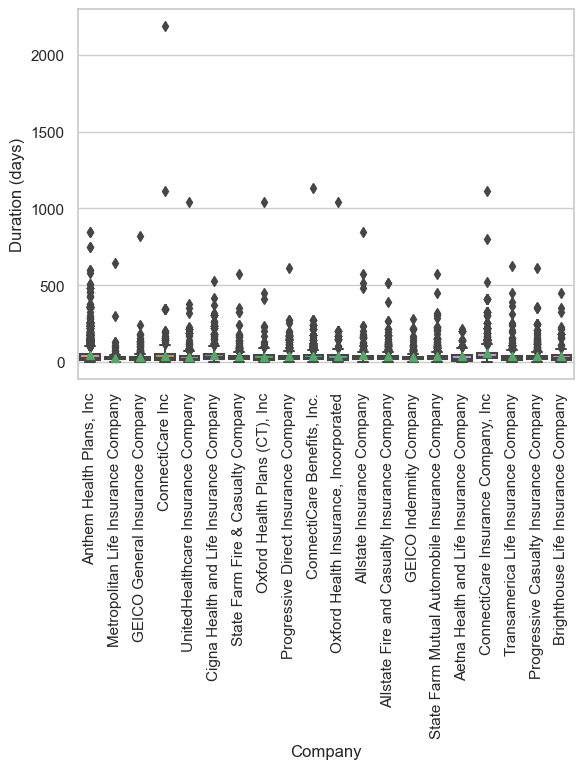

In [24]:
sns.boxplot(data=closed_cop, x="Company", y="duration", showfliers = True, showmeans = True)
plt.xlabel("Company")
plt.xticks(rotation=90)
plt.ylabel("Duration (days)")
plt.show()

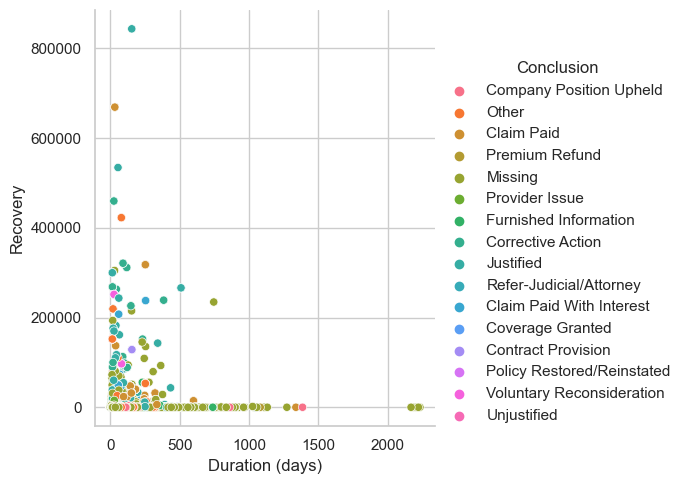

In [25]:
sns.relplot(x='duration',
            y='Recovery',
            data = closed,
            kind='scatter',
            hue = 'Conclusion')
plt.ylabel("Recovery")
plt.xlabel("Duration (days)")
plt.show();

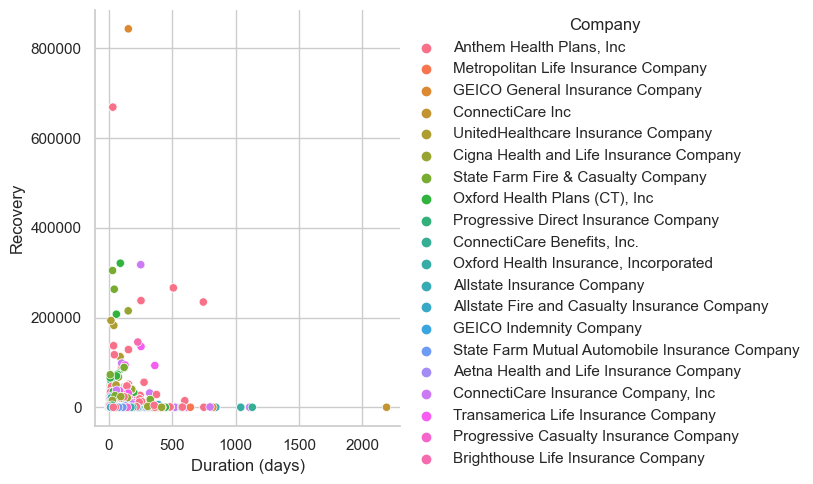

In [37]:
sns.relplot(x='duration',
            y='Recovery',
            data = closed_cop,
            kind='scatter',
            hue = 'Company')
plt.ylabel("Recovery")
plt.xlabel("Duration (days)")
plt.show();

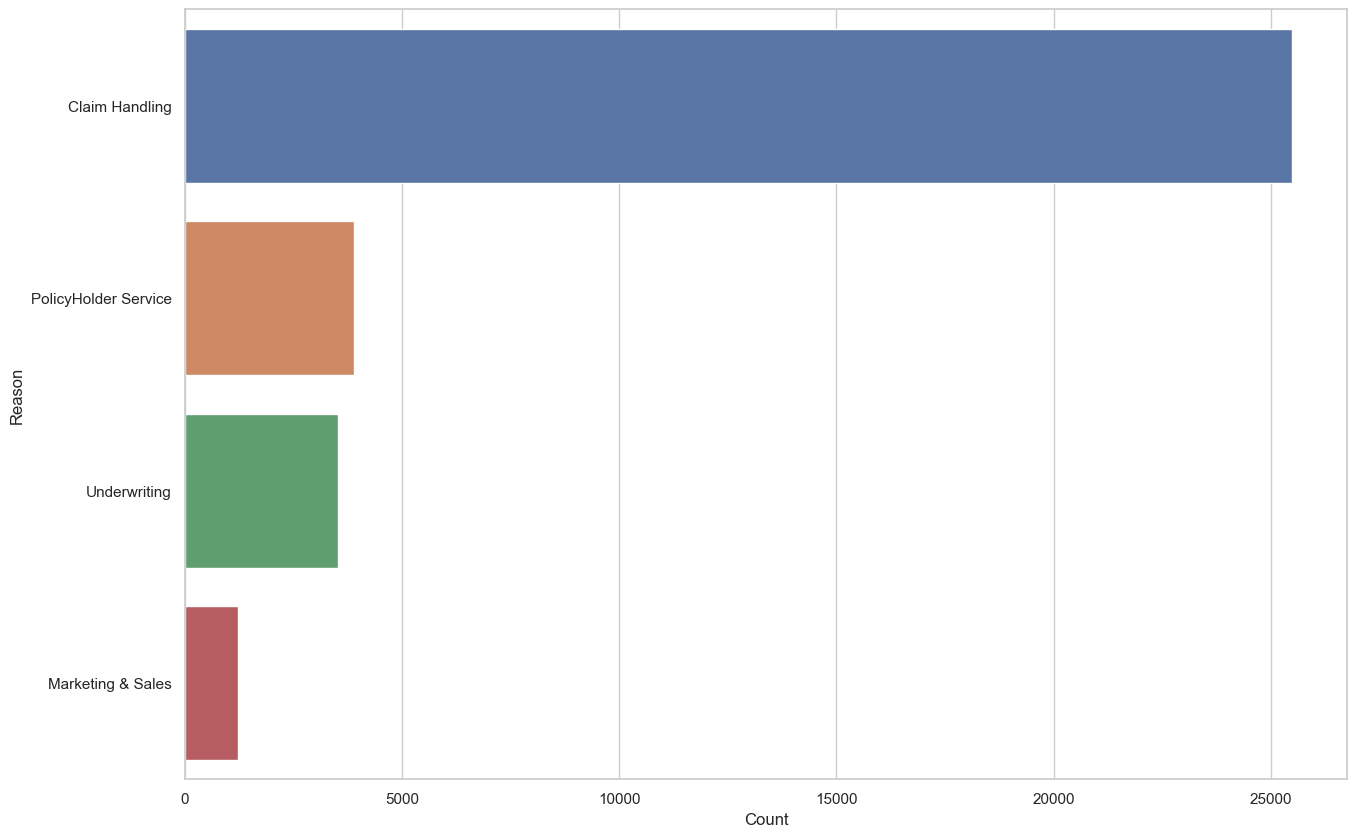

In [26]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10))

reason_c = closed.groupby(['Reason']).size().to_frame('Count').reset_index()
reason_c = reason_c.sort_values("Count", ascending=False).reset_index()
#closed_c = closed_c.iloc[:20,:]

sns.set_color_codes("muted")
sns.barplot(y = "Reason",  
            x = "Count", 
            data = reason_c,
            label = "Reason", 
            orient = "h")
plt.show();

(177, 2)


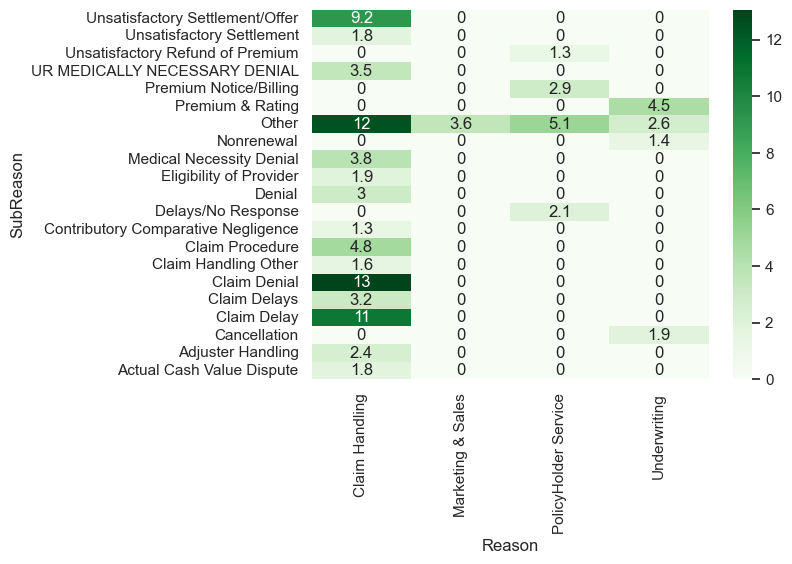

In [27]:
subreason_c = closed.groupby(['SubReason']).size().to_frame('Count').reset_index()
subreason_c = subreason_c.sort_values("Count", ascending=False).reset_index(drop=True)
print(subreason_c.shape)
subreason_c = subreason_c.iloc[:20,:]

subreason_a = closed.copy()
subreason_a.loc[~subreason_a.SubReason.isin(list(subreason_c.SubReason)), 'SubReason'] = 'Other'

cross_tab = pd.DataFrame(pd.crosstab(subreason_a['SubReason'], subreason_a.Reason, normalize='all'))
cross_tab = cross_tab * 100

ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
ax.invert_yaxis()
plt.show();

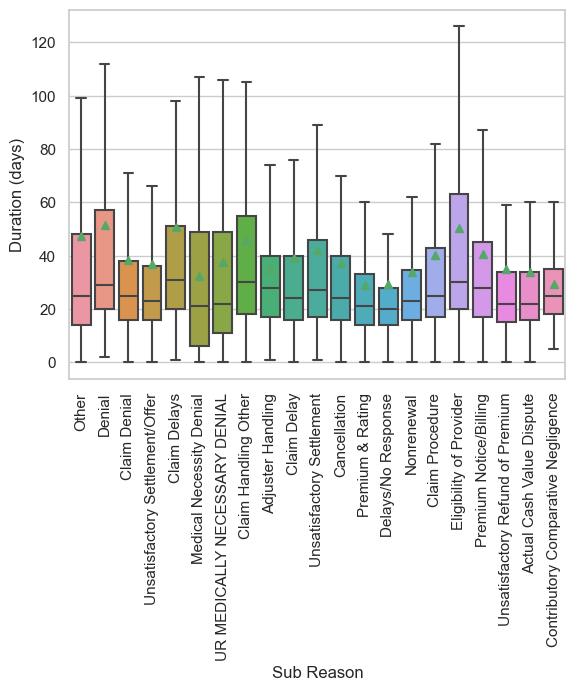

In [46]:
sns.boxplot(data=subreason_a, x="SubReason", y="duration", showfliers = False, showmeans = True)
plt.xlabel("Sub Reason")
plt.xticks(rotation=90)
plt.ylabel("Duration (days)")
plt.show()

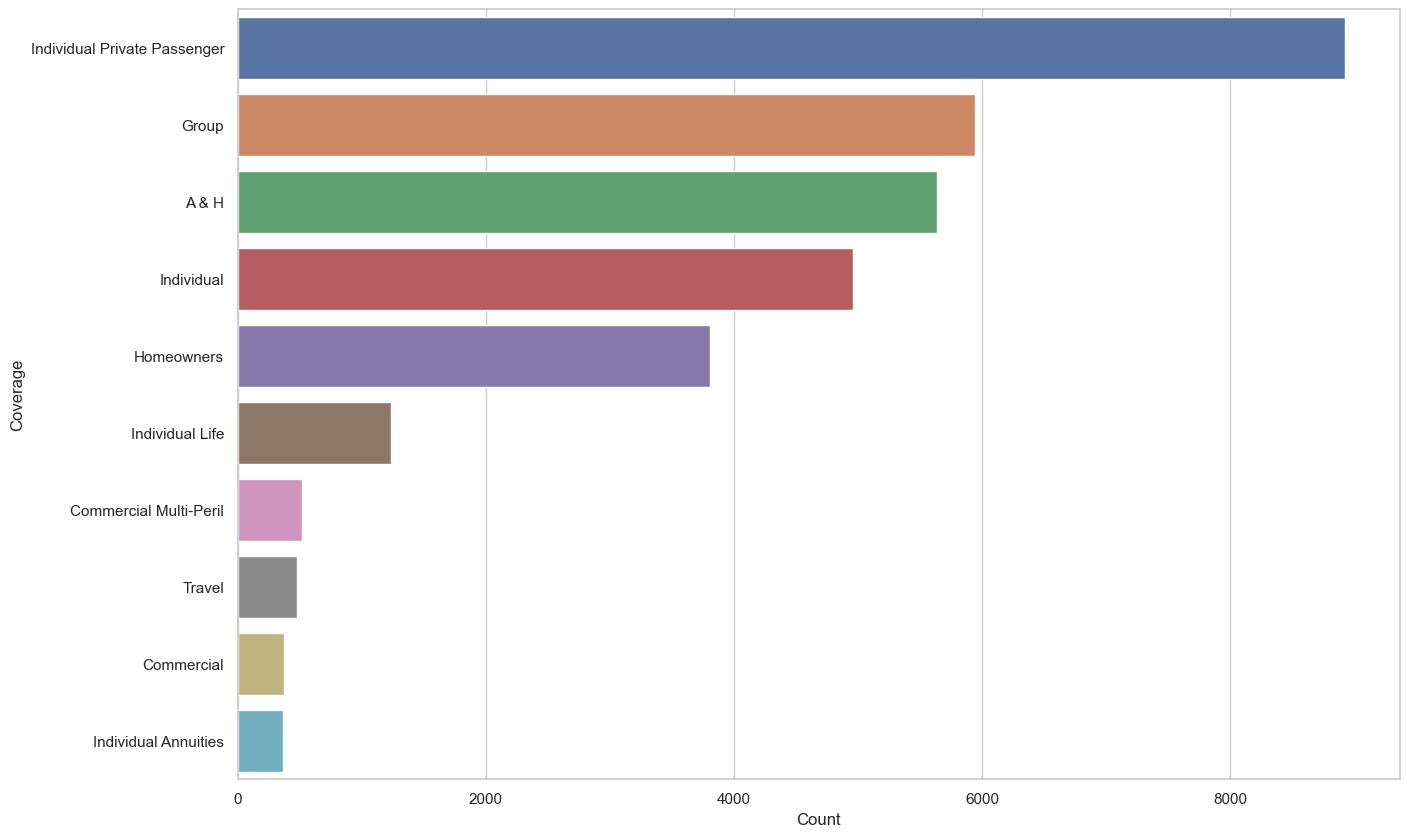

In [28]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10))

cover_c = closed.groupby(['Coverage']).size().to_frame('Count').reset_index()
cover_c = cover_c.sort_values("Count", ascending=False).reset_index(drop=True)
cover_c = cover_c.iloc[:10,:]

sns.set_color_codes("muted")
sns.barplot(y="Coverage", x="Count", 
            data=cover_c,
            label="Coverage", 
            orient = "h")
plt.show();

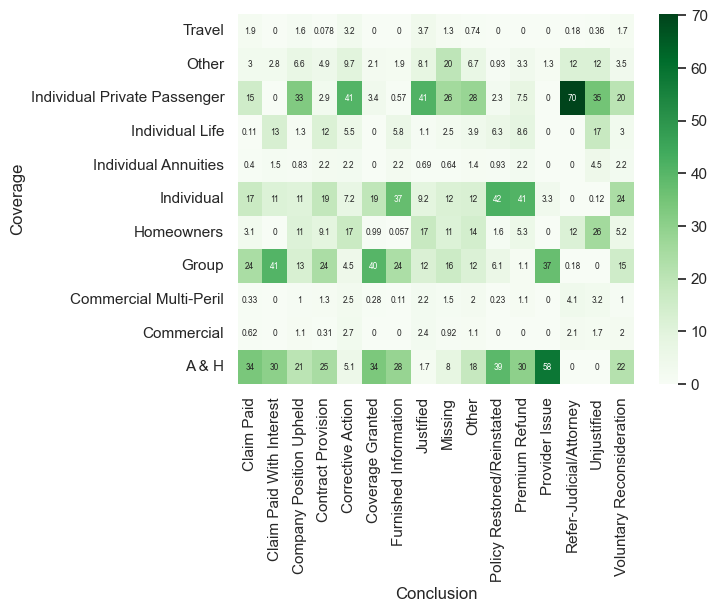

In [29]:
coverage_a = closed.copy()
coverage_a.loc[~coverage_a.Coverage.isin(list(cover_c.Coverage)), 'Coverage'] = 'Other'

cross_tab = pd.DataFrame(pd.crosstab(coverage_a['Coverage'], coverage_a.Conclusion, normalize='columns'))
cross_tab = cross_tab * 100

ax = sns.heatmap(cross_tab, annot = True, cmap="Greens", annot_kws={"fontsize":6})
ax.invert_yaxis()
plt.show();

### Predict the duration

In [102]:
mod_data = closed[~closed.Coverage.isna()]
mod_data = mod_data.drop(['File No.','Opened', 'Closed','Conclusion'], axis = 1)
for name in ['SubCoverage','Reason','Disposition','SubReason']:
       mod_data[name] = mod_data[name].fillna('Missing')
#mod_data[name] = mod_data[name].astype(str)
#mod_data = mod_data[mod_data.employment_type == 'FT']
#data.Conclusion = data.Conclusion.fillna('Missing')
y = mod_data.duration
X = mod_data.drop(['duration'], axis = 1)

In [103]:
print(list(X.columns))
X.head()

['Company', 'Coverage', 'SubCoverage', 'Reason', 'SubReason', 'Disposition', 'Recovery', 'Status']


,Company,Coverage,SubCoverage,Reason,SubReason,Disposition,Recovery,Status
0,Anthem_Health_Plans_Inc,Group,Health_Only,Claim_Handling,Medically_Necessary,Company_Position_Substantiated,0.00,Closed
1,Anthem_Health_Plans_Inc,Group,Health_Only,Claim_Handling,Provider_Contract_Issue,Claim_Settled,6467.30,Closed
2,Anthem_Health_Plans_Inc,A__H,Health_Only,Claim_Handling,Denial,Claim_Settled,147.58,Closed
3,Anthem_Health_Plans_Inc,Group,A__H,Claim_Handling,Provider_Contract_Issue,Claim_Settled,6467.30,Closed
4,Anthem_Health_Plans_Inc,A__H,A__H,Marketing__Sales,Duplicate_Coverage,Compromised_SettlementResolution,2179.32,Closed


In [104]:
check = X.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/X.shape[0]*100
check

,Count,perc
Company,0,0.0
Coverage,0,0.0
SubCoverage,0,0.0
Reason,0,0.0
SubReason,0,0.0
Disposition,0,0.0
Recovery,0,0.0
Status,0,0.0


#### Test-Train split

In [105]:
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# (27400, 12) (6849, 12) (27400,) (6849,)

TRAIN: [    9    68   178 ... 34246 34247 34248] TEST: [    0     1     2 ... 29906 31075 32604]
TRAIN: [    0     1     2 ... 34246 34247 34248] TEST: [  178   180   183 ... 31415 32710 33906]
TRAIN: [    0     1     2 ... 34246 34247 34248] TEST: [   68   185   186 ... 32434 32747 33962]
TRAIN: [    0     1     2 ... 34246 34247 34248] TEST: [    9   519  1278 ... 33315 33458 33800]
TRAIN: [    0     1     2 ... 33800 33906 33962] TEST: [ 1402  1427  2472 ... 34246 34247 34248]
(27400, 8) (6849, 8) (27400,) (6849,)


/Users/keithlowton/anaconda3/envs/Regressions/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


#### New features (not needed to rerun)

In [204]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
num_cols = num_cols
print(num_cols)

X_train_b = pd.concat([X_train,y_train], axis = 1)

for m_val in ['duration']:
    X_train_b[m_val + '_bin'], bin_edges  = pd.qcut(X_train_b[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train_b[m_val + '_bin']  = pd.cut(X_train_b[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train_b[m_val + '_bin']  = X_train_b[m_val + '_bin'].astype(str)
    X_train_b.loc[X_train_b[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

['Recovery']
duration [   0.   10.   15.   18.   21.   25.   29.   36.   49.   75. 2221.] range(0, 10)


In [205]:
cat_cols = X_train.select_dtypes(include=np.object).columns.tolist()
print(cat_cols)

['Company', 'Coverage', 'SubCoverage', 'Reason', 'SubReason', 'Disposition', 'Status']


/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_2786/382932747.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_cols = X_train.select_dtypes(include=np.object).columns.tolist()


In [206]:
ohe = OneHotEncoder()

cat_data = X_train_b[cat_cols]

ohe.fit(cat_data)
colnames = ohe.get_feature_names_out(list(cat_data.columns))

cat_data = ohe_dset(cat_data,list(cat_data.columns))
print(cat_data.shape)

(27400, 1031)
(27400, 1031)


In [216]:
cat_data = cat_data.reset_index(drop = True)
X_train_b = X_train_b.reset_index(drop = True)
X_tree = pd.concat([X_train_b[num_cols + ['duration_bin']], cat_data], axis = 1)

In [217]:
pd.crosstab(X_tree.duration_bin, columns = 'Count')
X_tree.loc[(X_tree.duration_bin.isin(['0','1'])),'duration_class'] = 0
X_tree.loc[(X_tree.duration_bin.isin(['8','9'])),'duration_class'] = 1
pd.crosstab(X_tree.duration_class, columns = 'Count')

X_tree = X_tree.drop(['duration_bin'], axis = 1)

In [218]:
#cat_cols.remove('Country')
a = list(X_tree.columns)
a.sort()
print(a)

['Company_21st_Century_Premier_Insurance_Company', 'Company_AAA_Life_Insurance_Company', 'Company_ACE_American_Insurance_Company', 'Company_ACE_Fire_Underwriters_Insurance_Company', 'Company_ACE_Property__Casualty_Insurance_Company', 'Company_AGCS_Marine_Insurance_Company', 'Company_AIG_Assurance_Company', 'Company_AIG_Property_Casualty_Company', 'Company_AIG_Specialty_Insurance_Company', 'Company_AIX_Specialty_Insurance_Company', 'Company_AXIS_Insurance_Company', 'Company_Acadia_Insurance_Company', 'Company_Accendo_Insurance_Company', 'Company_Acceptance_Indemnity_Insurance_Company', 'Company_Accident_Fund_Insurance_Company_of_America', 'Company_Accident_Fund_National_Insurance_Company', 'Company_Accordia_Life_and_Annuity_Company', 'Company_Accredited_Specialty_Insurance_Company', 'Company_Admiral_Insurance_Company', 'Company_Aegis_Security_Insurance_Company', 'Company_Aetna_Better_Health_Inc_', 'Company_Aetna_Health_Inc', 'Company_Aetna_Health_and_Life_Insurance_Company', 'Company_Ae

In [219]:
X_tree = X_tree[~X_tree.duration_class.isna()]
print(X_tree.shape)
y = X_tree.duration_class
X = X_tree.drop(['duration_class'], axis = 1)
try:
    X = X.drop(['duration_class'], axis = 1)
except:
    X = X

(11863, 1033)


In [220]:
check = X.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/X.shape[0]*100
check

,Count,perc
Recovery,0,0.0
Company_21st_Century_Premier_Insurance_Company,0,0.0
Company_AAA_Life_Insurance_Company,0,0.0
Company_ACE_American_Insurance_Company,0,0.0
Company_ACE_Fire_Underwriters_Insurance_Company,0,0.0
...,...,...
Status_Recovery_Pending,0,0.0
Status_Reopened,0,0.0
Status_Sent_to_Agent,0,0.0
Status_Sent_to_Company,0,0.0


In [222]:
clf = DecisionTreeClassifier(max_depth=5, random_state=1234)
model = clf.fit(X, y)

text_representation = tree.export_text(clf, feature_names=list(X.columns))

In [223]:
rule_lst = []
flattened_lst = []
flattened_lsts = []

for split_size in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    X_trees, X_tree_test, y_trees, y_tree_test = train_test_split(X,
                                                                  y,
                                                                  test_size = split_size,
                                                                  stratify = y,
                                                                  random_state = 222)
    print(X_trees.shape, y_trees.shape)
    
    model = clf.fit(X_trees, y_trees)
    text_representation = tree.export_text(clf, feature_names=list(X_trees.columns))
    rules, proba = get_rules(clf, list(X_trees.columns), [0,1], 80, 200)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

for i in range(len(flattened_lst)):
    flattened_lsts.append(flattened_lst[i].split(' then class')[0])
flattened_lsts = list(set(flattened_lsts))

 12%|█▎        | 1/8 [00:00<00:01,  4.08it/s]

(10676, 1032) (10676,)


 25%|██▌       | 2/8 [00:00<00:01,  4.01it/s]

(9490, 1032) (9490,)


 38%|███▊      | 3/8 [00:00<00:01,  4.24it/s]

(8304, 1032) (8304,)


 50%|█████     | 4/8 [00:00<00:00,  4.42it/s]

(7117, 1032) (7117,)
(5931, 1032) (5931,)


 75%|███████▌  | 6/8 [00:01<00:00,  5.37it/s]

(4745, 1032) (4745,)
(3558, 1032) (3558,)


100%|██████████| 8/8 [00:01<00:00,  5.21it/s]

(2372, 1032) (2372,)


In [224]:
flattened_lsts

['if (Recovery > 41.46) and (Company_Anthem_Health_Plans_Inc > 0.5) and (Recovery > 1496.73) and (SubReason_Unsatisfactory_Settlement <= 0.5) and (SubReason_Unsatisfactory_Refund_of_Premium <= 0.5)',
 'if (Recovery > 41.46) and (Company_Anthem_Health_Plans_Inc > 0.5) and (Recovery > 1496.73) and (SubCoverage_Exchange_Individual_Health <= 0.5) and (SubReason_Unsatisfactory_Refund_of_Premium <= 0.5)',
 'if (Recovery > 41.46) and (Company_Anthem_Health_Plans_Inc > 0.5) and (Recovery > 1496.73) and (SubReason_Unsatisfactory_Refund_of_Premium <= 0.5) and (SubReason_UR_DENIAL_OF_CLAIM <= 0.5)',
 'if (Recovery > 41.46) and (Company_Anthem_Health_Plans_Inc > 0.5) and (Recovery > 1496.73) and (SubCoverage_Exchange_Individual_Health <= 0.5) and (SubReason_UR_DENIAL_OF_CLAIM <= 0.5)',
 'if (Recovery <= 41.46) and (Disposition_No_Action_RequestedRequired > 0.5) and (SubReason_Policy_Service_Delay <= 0.5) and (Reason_Marketing__Sales <= 0.5) and (Company_American_National_General_Insurance_Company 

### New features

In [228]:
for i, dset in enumerate([X_train, X_test]):

    dseta = dset.copy()
    dseta['feature_1'] = 0
    dseta.loc[(dseta.Company == 'Anthem_Health_Plans_Inc') & 
              (dseta.Recovery > 1496.73) & 
              (dseta.SubReason == 'Unsatisfactory_Settlement') & 
              (dseta.SubReason != 'Unsatisfactory_Refund_of_Premium'), 'feature_1'] = 1
    dseta['feature_2'] = 0
    dseta.loc[(dseta.Company == 'Anthem_Health_Plans_Inc') &
              (dseta.Recovery > 1496.73) & 
              (dseta.SubCoverage != 'Exchange_Individual_Health') & 
              (dseta.SubReason != 'Unsatisfactory_Refund_of_Premium'), 'feature_2'] = 1    
    dseta['feature_3'] = 0
    dseta.loc[(dseta.Company == 'Anthem_Health_Plans_Inc') & 
              (dseta.Recovery > 1496.73) & 
              (dseta.SubReason != 'Unsatisfactory_Refund_of_Premium') &
              (dseta.SubReason != 'UR_DENIAL_OF_CLAIM'), 'feature_3'] = 1        
    dseta['feature_4'] = 0
    dseta.loc[(dseta.Company == 'Anthem_Health_Plans_Inc') & 
              (dseta.Recovery > 1496.73) & 
              (dseta.SubCoverage != 'Exchange_Individual_Health') & 
              (dseta.SubReason != 'UR_DENIAL_OF_CLAIM'), 'feature_4'] = 1            
    dseta['feature_5'] = 0
    dseta.loc[(dseta.Recovery <= 41.46) & 
              (dseta.Disposition == 'No_Action_RequestedRequired') & 
              (dseta.SubReason != 'Policy_Service_Delay') & 
              (dseta.Reason != 'Marketing__Sales') & 
              (dseta.Company != 'American_National_General_Insurance_Company'), 'feature_5'] = 1                
    

    if i == 0:
        X_train = dseta
    elif i == 1:
        X_test = dseta      

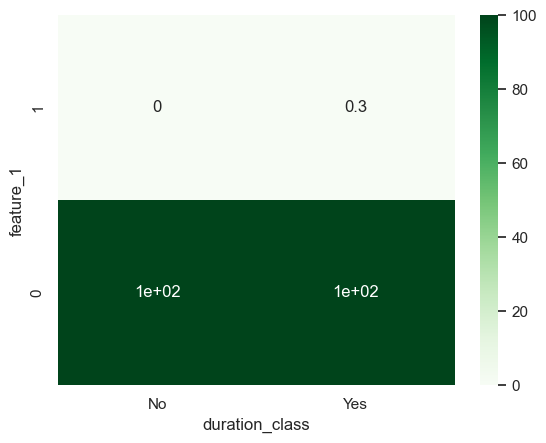

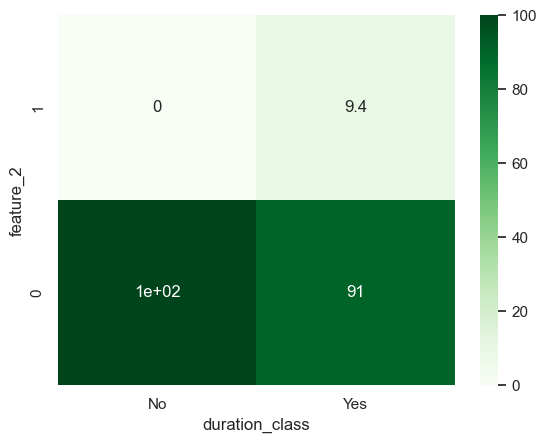

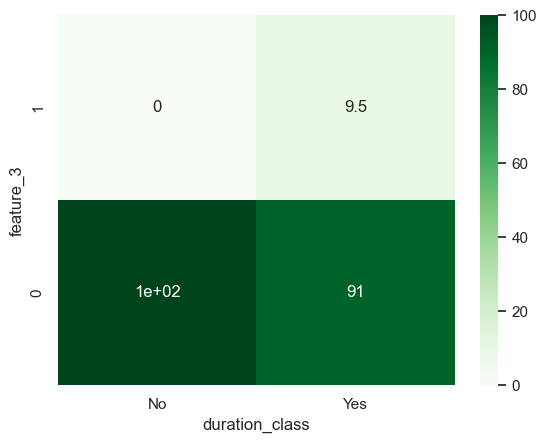

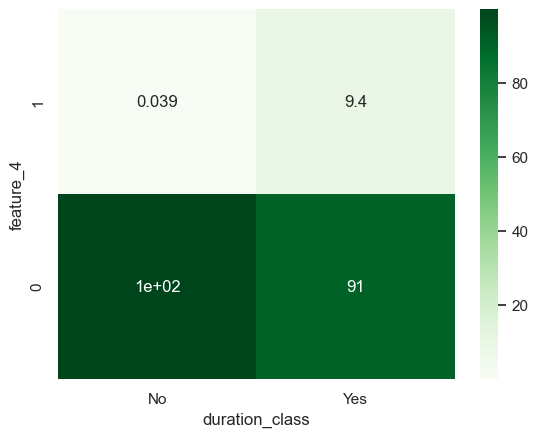

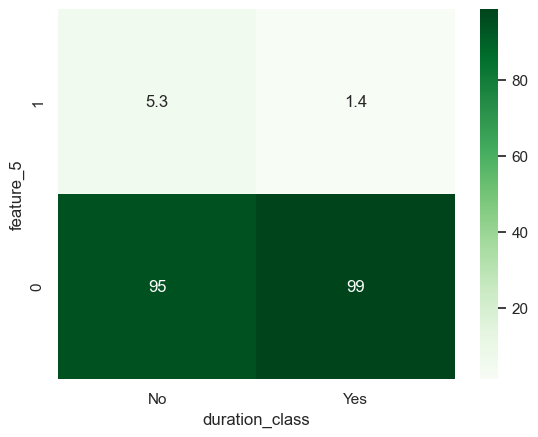

In [234]:
X_train_b = pd.concat([X_train,y_train], axis = 1)

X_train_b.loc[(X_train_b.duration < 10),'duration_class'] = 'No'
X_train_b.loc[(X_train_b.duration > 75),'duration_class'] = 'Yes'
feat_check = X_train_b[~X_train_b.duration_class.isna()]

for name in [col for col in feat_check.columns if 'feature_' in col]:
    cross_tab = pd.DataFrame(pd.crosstab(feat_check[name], feat_check.duration_class, normalize='columns'))
    cross_tab = cross_tab * 100

    ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show();

#### Mutual information

In [68]:
y = y_train.copy()
X = X_train.copy()

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
discrete_features = X.dtypes == int

In [43]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Recovery       0.598577
Company        0.503732
SubReason      0.359477
SubCoverage    0.178885
Disposition    0.131173
Coverage       0.112720
Reason         0.040310
Status         0.020772
Name: MI Scores, dtype: float64

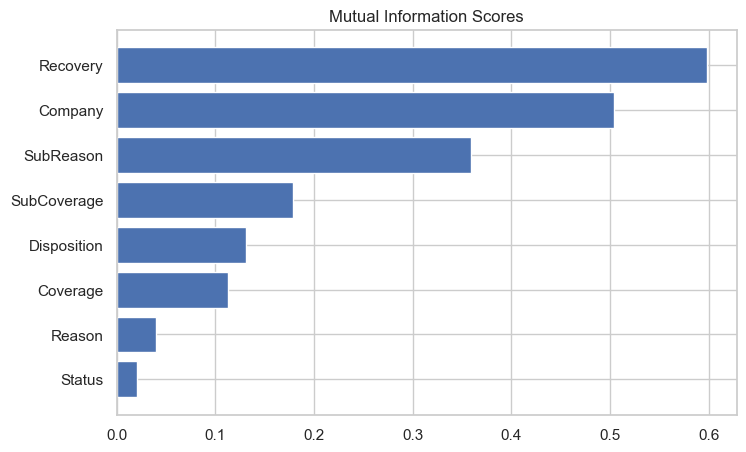

In [44]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.show();

#### Numeric data

In [235]:
print(X_train.columns)

Index(['Company', 'Coverage', 'SubCoverage', 'Reason', 'SubReason',
       'Disposition', 'Recovery', 'Status', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5'],
      dtype='object')


In [236]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

[]


In [237]:
try:
    X_train = X_train.drop(lst, axis=1)
    X_test = X_test.drop(lst, axis=1)
except:
    X_train = X_train
    X_test = X_test

In [239]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)
vif[(vif.VIF > 10)]


['feature_2', 'feature_3', 'feature_4']


,Features,VIF
2,feature_2,397.497286
3,feature_3,54.028522
4,feature_4,397.500325


In [240]:
try:
    X_train = X_train.drop(to_drop_vif, axis=1)
    X_test = X_test.drop(to_drop_vif, axis=1)
except:
    X_train = X_train
    X_test = X_test

In [241]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
print(num_cols)
#sns.pairplot(X_train[num_cols])
#plt.show();

['Recovery']


/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_2786/3896738982.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


[]


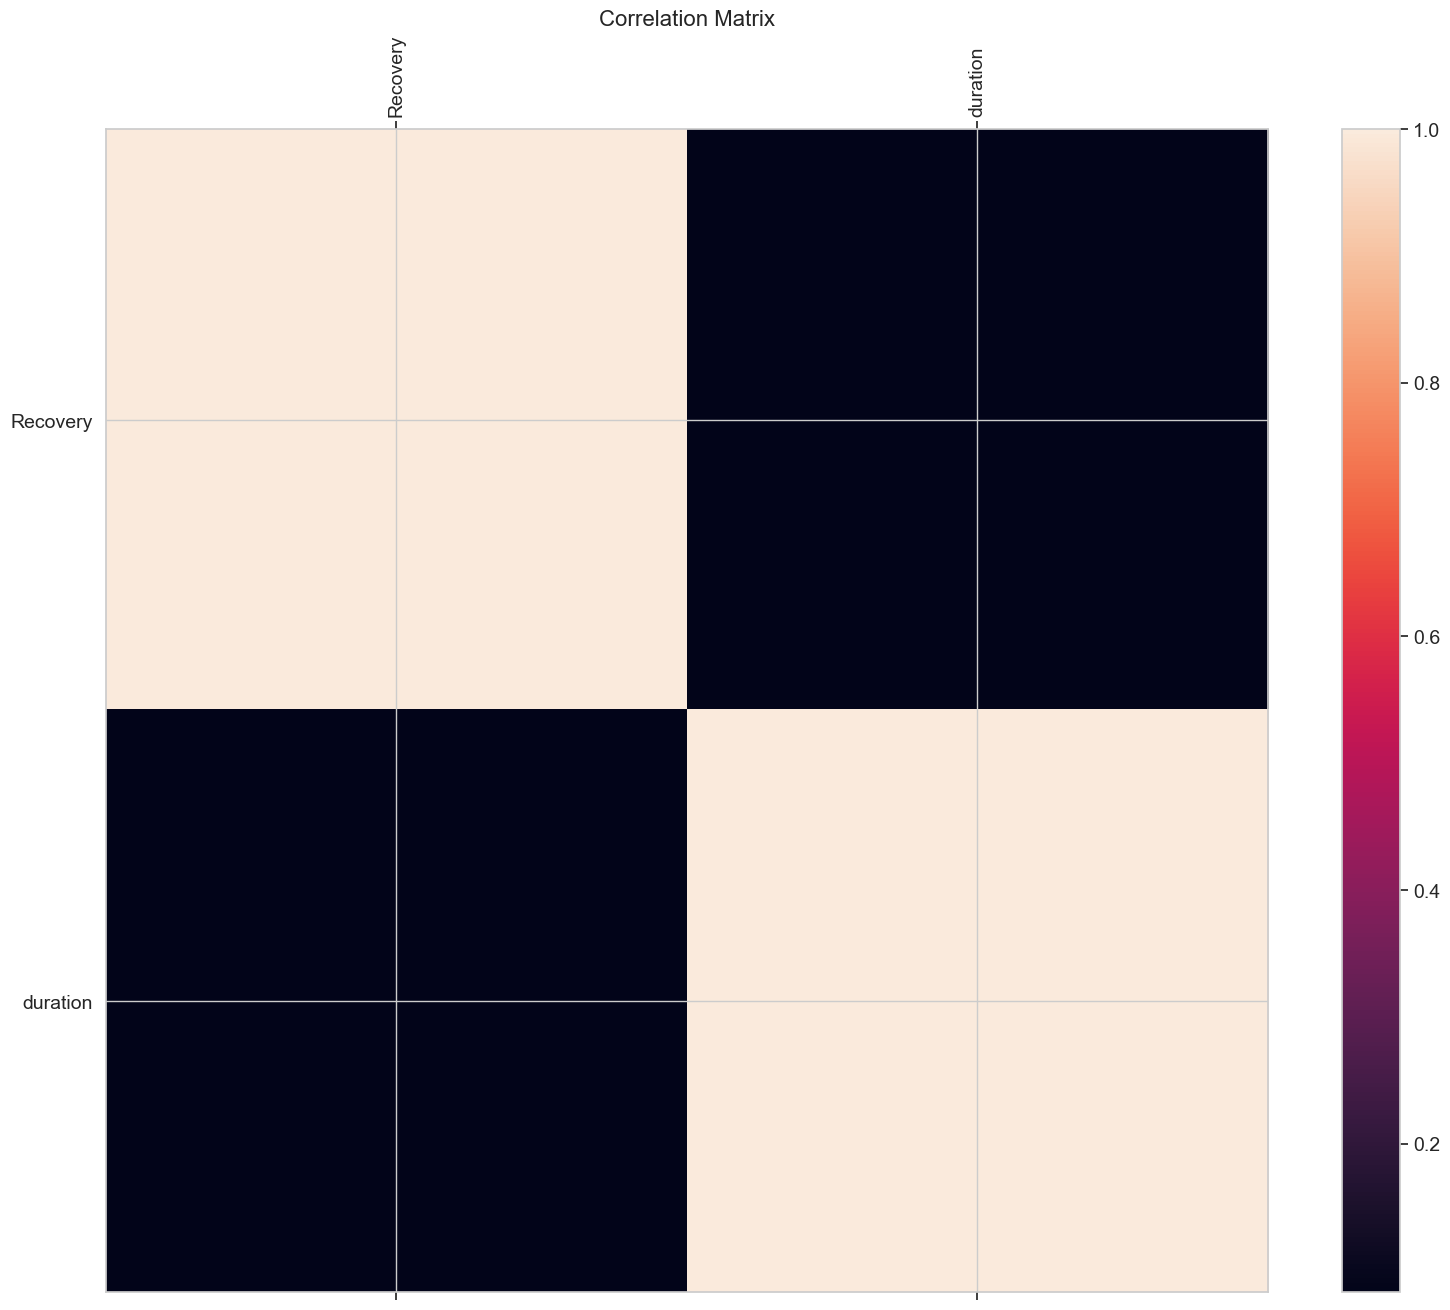

In [242]:
###################
### Correlation ###
###################

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [243]:
#####################
### MinMax scaler ###
#####################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###

(27400, 1)
(27400, 1)
(6849, 1)


#### Categorical data

In [244]:
cat_cols = list(X_train.select_dtypes(include=['object']))
print(cat_cols)

['Company', 'Coverage', 'SubCoverage', 'Reason', 'SubReason', 'Disposition', 'Status']


In [245]:
###################################
### High cardinality adjustment ###
###################################

card_vars = []
cat_data = X_train[cat_cols]
for i in range(cat_data.shape[1]):
    X_train.loc[X_train[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'
    X_test.loc[X_test[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'

    if (cat_data.iloc[:,i].nunique() > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        X_train.loc[~X_train[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        X_test.loc[~X_test[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    if (len(list(set(cat_data.iloc[:,i]))) > 100):
        card_vars.append(cat_data.columns[i])

print(card_vars)

Company 679
SubCoverage 102
SubReason 171
['Company', 'SubCoverage', 'SubReason']


In [246]:
########################
### One hot encoding ###
########################

ohe = OneHotEncoder()
print(X_train.shape)
# (1808, 10)

### Train ###

ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(X_train,cat_cols)  ### Train ###
cat_data_test = ohe_dset(X_test,cat_cols)    ### Test ###

(27400, 10)
(27400, 142)
(6849, 124)


In [247]:
print([col for col in X_train.columns if 'feature_' in col])
bin_data_train = X_train[[col for col in X_train.columns if 'feature_' in col]]
bin_data_test = X_test[[col for col in X_train.columns if 'feature_' in col]]

['feature_1', 'feature_5']


In [251]:
cat_data_train = cat_data_train[(list(set(list(cat_data_train.columns)) - set(['level_0', 'index'])))]
num_data_train = num_data_train[(list(set(list(num_data_train.columns)) - set(['level_0', 'index'])))]
#ord_data_train = ord_data_train[(list(set(list(ord_data_train.columns)) - set(['level_0', 'index'])))]
bin_data_train = bin_data_train[(list(set(list(bin_data_train.columns)) - set(['level_0', 'index'])))]

cat_data_test = cat_data_test[(list(set(list(cat_data_test.columns)) - set(['level_0', 'index'])))]
num_data_test = num_data_test[(list(set(list(num_data_test.columns)) - set(['level_0', 'index'])))]
#ord_data_test = ord_data_test[(list(set(list(ord_data_test.columns)) - set(['level_0', 'index'])))]
bin_data_test = bin_data_test[(list(set(list(bin_data_test.columns)) - set(['level_0', 'index'])))]

In [252]:
print("Categorical data", list(cat_data_train.columns))
print("Numerical data", list(num_data_train.columns))
#print("Ordinal data", list(ord_data_train.columns))
print("Binned data", list(bin_data_train.columns))

Categorical data ['Status_Reopened', 'Coverage_Portable_Electronics_Ins', 'Coverage_Individual', 'SubReason_DelaysNo_Response', 'SubReason_Unsatisfactory_Settlement', 'SubReason_Claim_Delay', 'SubReason_Medical_Necessity_Denial', 'Company_ConnectiCare_Inc', 'SubCoverage_Hazard', 'Disposition_Compromised_SettlementResolution', 'Disposition_Insufficient_Information', 'Disposition_Referred_to_Another_State’s_Dept_of_Insurance', 'Company_Aetna_Health_and_Life_Insurance_Company', 'Coverage_Other_[Enter_Coverage]', 'Coverage_Mobile_Homeowner', 'SubReason_Claim_Procedure', 'Disposition_Referred_to_Other_Division_for_Possible_Disciplinary_Action', 'Coverage_Group', 'Company_Transamerica_Life_Insurance_Company', 'Disposition_Claim_Settled', 'SubCoverage_A__H', 'Disposition_Missing', 'SubReason_Other', 'Company_Metropolitan_Life_Insurance_Company', 'SubCoverage_Health_Exchange', 'Coverage_CondoTownhome', 'Coverage_Life_and_Annuity', 'Company_Genworth_Life_Insurance_Company', 'Coverage_IRA', 'Sub

In [253]:
###########################
### Bring data together ###
###########################

print(cat_data_train.shape, num_data_train.shape, bin_data_train.shape)
cat_data_train = cat_data_train.reset_index(drop = True)
num_data_train = num_data_train.reset_index(drop = True)
bin_data_train = bin_data_train.reset_index(drop = True)

X_train = pd.concat([cat_data_train,num_data_train],axis = 1)
print(X_train.shape)
X_train = pd.concat([X_train,bin_data_train],axis = 1)
print(X_train.shape)

print(cat_data_test.shape, num_data_test.shape, bin_data_test.shape)
cat_data_test = cat_data_test.reset_index(drop = True)
num_data_test = num_data_test.reset_index(drop = True)
bin_data_test = bin_data_test.reset_index(drop = True)
X_test = pd.concat([cat_data_test,num_data_test],axis = 1)
X_test = pd.concat([X_test,bin_data_test],axis = 1)

print(X_train.shape, X_test.shape)

# (39116, 60) (9779, 60)

(27400, 142) (27400, 1) (27400, 2)
(27400, 143)
(27400, 145)
(6849, 124) (6849, 1) (6849, 2)
(27400, 145) (6849, 127)


In [254]:
####################################################
### Check that train/test sets have same columns ###
####################################################

mod_cols = (list(set(list(X_train.columns)) - set(['index'])))
X_train_mod = X_train[mod_cols]
miss_lst = list(set(list(X_train.columns)) - set(list(X_test.columns)))

for name in miss_lst:
    X_test[name] = 0
X_test = X_test[list(X_train_mod.columns)]

drop_test_lst = list(set(list(X_test.columns)) - set(list(X_train_mod.columns)))
X_test_mod = X_test.drop(drop_test_lst, axis = 1)


print(X_train_mod.shape, X_test_mod.shape)
# (64215, 105) (42811, 135) (10148, 107)


(27400, 145) (6849, 145)


### Models

#### Gradient Boosting Regressor

In [256]:
gbr = GradientBoostingRegressor(random_state=0)

In [257]:
GradientBoostingRegressor().get_params().keys

<function dict.keys>

In [ ]:
gbr_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

gbr_gridsearch = GridSearchCV(gbr, gbr_param_grid, cv = 5, verbose = 2)

gbr_gridsearch.fit(X_train_mod, y_train)

print("Best parameters: ", gbr_gridsearch.best_params_)
# Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
print("Cross Validation Score: ", gbr_gridsearch.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   4.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   8.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   8.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   8.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   8.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   8.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=50; total time=   2.2s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=8, n_estimators=50; total time=   2.1s
[CV] END learning_rate=0.1, max_depth=3, min_sampl

[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  14.3s
[CV] END learning_rate=0.1, max_depth=5, min_samp

In [ ]:
gbr_hyp = GradientBoostingRegressor(random_state=0,
                                    learning_rate = gbr_gridsearch.best_params_['learning_rate'],
                                    n_estimators = gbr_gridsearch.best_params_['n_estimators'],
                                    max_depth = gbr_gridsearch.best_params_['max_depth'],
                                    min_samples_split = gbr_gridsearch.best_params_['min_samples_split'],
                                    min_samples_leaf = gbr_gridsearch.best_params_['min_samples_leaf'])

In [ ]:
gbr_valid_score = gbr_gridsearch.score(X_test, y_test)

print("Validation Score: ", gbr_valid_score)

gbr_hyp.fit(X_train, y_train)

# MAE:  2.230827876694104
# RMSE:  3.1949612716361906

gbr_mae, gbr_rmse, gbr_r2 = diag_vals(gbr_hyp)